# Debug Stacking
Here we examine how stacking affects the peak amplitudes of the raw waveforms. We look at daily stacks and noise levels in the correlation coda's.

In [4]:
using SeisIO, SeisNoise, CSV, Dates, JLD2, HDF5, Glob, Plots, ColorSchemes, Statistics

In [5]:
loadcolorscheme(:cm_maxamp,ColorSchemes.gist_heat.colors[end-50:-1:1], "maxamp color", "for waveform plot");

## Compare Stacks at intersection

In [6]:
SVD_B4 = glob("nodes/corr_large/*/*/CI.SVD..NO.B4*","/Volumes/T7/seis_data")
filter!(x -> any(occursin.(["$int" for int in collect(15:24)],basename(x))), SVD_B4);

SVD_B1 = glob("nodes/corr_large/*/*/CI.SVD..NO.B11*","/Volumes/T7/seis_data")
filter!(x -> any(occursin.(["$int" for int in collect(50:60)],basename(x))), SVD_B1);

In [7]:
function jld2_corrs(files::Array{String,1}, key::String = "ZZ")
    ar_corrs = []
    for file in files
        f = jldopen(file,"r")
        corrs = [f[key][k] for k in keys(f[key])]
        close(f)
        push!(ar_corrs, corrs)
    end
    ar = collect(Iterators.flatten(ar_corrs))
    return ar
end

jld2_corrs (generic function with 2 methods)

In [8]:
B4 = jld2_corrs(filter(x -> occursin("23", basename(x)), SVD_B4));

In [9]:
B1 = jld2_corrs(filter(x -> occursin("57", basename(x)), SVD_B1));

## Plot day stacks to check interference
We want to check whether the day stacks don't line up well enough on B1 to produce as strong a stack as B4

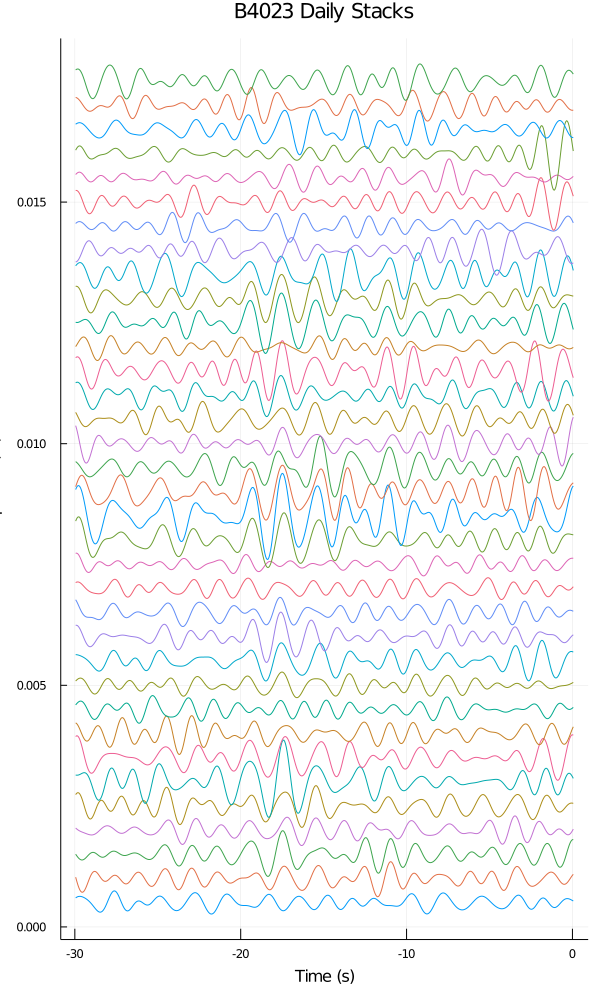

In [10]:
B4_daily = plot(title="B4023 Daily Stacks", legend=false, size=(600,1000),
            xticks = (0:200:600, -30:10:0), xlabel="Time (s)", ylabel="Amplitude (m)")
for (ind, corr) in enumerate(B4)
    plot!(B4_daily, bandpass(corr,0.4,0.8).corr[5400:6000] .+ 0.0005*ind, label = corr.id, linewidth=1)
end
#png("/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/B4023_Daily_Stacks_offset_medf_10sec.png")
display(B4_daily)

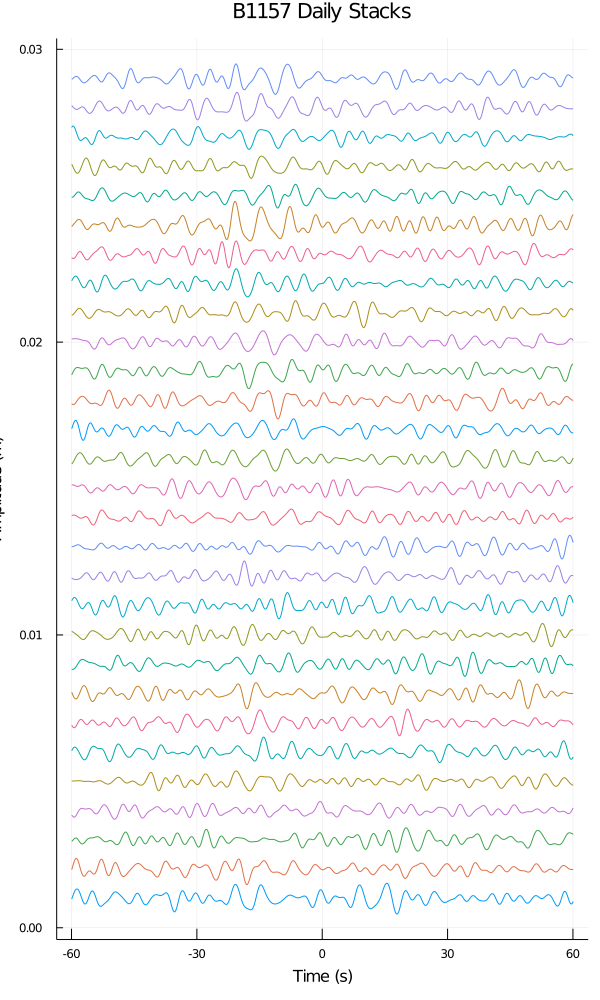

In [12]:
B1_daily = plot(title="B1157 Daily Stacks", legend=false, size=(600,1000),
            xticks = (0:600:2400, -60:30:60), xlabel="Time (s)", ylabel="Amplitude (m)")
for (ind, corr) in enumerate(B1)
    plot!(B1_daily, bandpass(corr,0.1,0.35).corr[4800:7200] .+ 0.001*ind, label = corr.id, linewidth=1)
end
#png("/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/B1157_Daily_Stacks_offset.png")
display(B1_daily)

In [72]:
# single day comparison - above plots are aggrigated 
ind=10
plot(bandpass(taper(B4[ind]), 0.1,0.35).corr[4800:7200], label ="$(B4[ind].name)")
plot!(bandpass(taper(B1[ind]), 0.1,0.35).corr[4800:7200], label="$(B1[ind].name)")
plot!(title="B1/B4 Single Day Comparison 2", xlabel = "Time (fs=20) - 1 min +/-", ylabel="Amplitude", dpi=200)
#png("/Users/julianschmitt/Desktop/SeisPlots2/B4023_B1157_1_min_single_day2.png")

## Stacked Comparisons

In [74]:
function sum_corrs(corrs::Array{CorrData,1})
    """ Implement sum function on array of corrs before stacking"""
    sum_corr = Array{Float64, 2}(undef, size(corrs[1].corr)[1], length(corrs))
    for (ind, corr) in enumerate(corrs)
        sum_corr[:, ind] = corr.corr[:]
    end
    corr = deepcopy(corrs[1]) # keep metadata from first correlation
    corr.corr = sum_corr # update array of correlations
    return corr
end   
function cc_medianmute(A::AbstractArray, cc_medianmute_α::Float64 = 10.0)
    """
        Remove noisy correlation windows before stacking
        - Remove if average noise is greater than 10x the average
    """
    T, N = size(A)
    cc_maxamp = vec(maximum(abs.(A), dims=1))
    cc_medianmax = median(cc_maxamp)
    inds = findall(x-> x <= cc_medianmute_α*cc_medianmax,cc_maxamp)
    return A[:, inds], inds
end
remove_medianmute(C::CorrData, inds) = (return C.t[inds])
function cc_medianmute!(C::CorrData, cc_medianmute_α::Float64 = 10.0, bool::Bool = true)
    C.corr, inds = cc_medianmute(C.corr, cc_medianmute_α)
    if bool
        C.t = remove_medianmute(C, inds)
    end
    return nothing
end
function stack_corrs(corrs::Array{CorrData,1})
    new_method = sum_corrs(corrs)
    cc_medianmute!(new_method, 3., false)
    SeisNoise.stack!(new_method, allstack=true, stacktype = mean)
    return new_method
end

stack_corrs (generic function with 1 method)

In [81]:
B4_stacked = Array{CorrData,1}(undef, 0)
for sta in collect(15:24)
    B4_sta = jld2_corrs(filter(x -> occursin("$sta", basename(x)), SVD_B4))
    if typeof(B4_sta) ==Array{Any,1}
        continue
    end
    B4_stack = stack_corrs(B4_sta)
    push!(B4_stacked, B4_stack)
end
B1_stacked = Array{CorrData,1}(undef, 0)
for sta in collect(55:58)
    B1_sta = jld2_corrs(filter(x -> occursin("$sta", basename(x)), SVD_B1))
    B1_stack = stack_corrs(B1_sta)
    push!(B1_stacked, B1_stack)
end

In [112]:
#plot([bandpass(taper(c),0.1,0.35).corr for c in B4_stacked])
B4_plot = plot(title="B4 Intersection stacked correlations ZZ B4015-B4024", ylabel="Amplitude", 
                xlabel="Time (+/- 1 min)", legend=:outertopright, size=(900,450), dpi=200, pad=0.5)
for corr in B4_stacked
    plot!(B4_plot, bandpass(taper(corr), 0.1,0.35).corr[4800:7200], label= corr.name)
end
#png("/Users/julianschmitt/Desktop/SeisPlots2/B4_intersection_stacked_corrs.png")
#display(B4_plot)

In [115]:
B1_plot = plot(title="B1 Intersection stacked correlations ZZ B4055-B4058", ylabel="Amplitude", 
                xlabel="Time (+/- 1 min)", legend=:outertopright, size=(900,450), dpi=200, pad=0.5)
for corr in B1_stacked
    plot!(B1_plot, bandpass(taper(corr), 0.1,0.35).corr[4800:7200], label= corr.name)
end
png("/Users/julianschmitt/Desktop/SeisPlots2/B1_intersection_stacked_corrs.png")
#display(B1_plot)

In [111]:
CHN_B4_files = glob("nodes/corr_large/*/*/CI.CHN..NO.B406*", "/Volumes/T7/seis_data")
CHN_B1_files = glob("nodes/corr_large/*/*/CI.CHN..NO.B1156*", "/Volumes/T7/seis_data")

2-element Array{String,1}:
 "/Volumes/T7/seis_data/nodes/corr_large/2019/December/CI.CHN..NO.B1156.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/November/CI.CHN..NO.B1156.--.jld2"

In [121]:
# Plot together to compare amplitudes
B1_and_B4 = plot(title="B1 and B4 stacked comparison plot at Intersection: Full", ylabel="Amplitude",
                 xlabel="Time (+/- 1 min)", legend=:outertopright, size=(900,450), dpi=200, pad=0.5)
for corr in B4_stacked
    plot!(B1_and_B4, bandpass(taper(corr), 0.1,0.35).corr, label= corr.name, color="blue")
end
for corr in B1_stacked
    plot!(B1_and_B4, bandpass(taper(corr), 0.1,0.35).corr, label= corr.name, color="red")
end
png("/Users/julianschmitt/Desktop/SeisPlots2/B1_and_B4_intersection_stacked_comparison_noise_uni_color.png")
#display(B1_and_B4)

In [123]:
B4_sample_sum = sum(abs.(B4_stacked[1].corr[1:4000])) +sum(abs.(B4_stacked[1].corr[1:7500]))
B1_sample_sum = sum(abs.(B1_stacked[1].corr[1:4000])) +sum(abs.(B4_stacked[1].corr[1:7500]))
println("B4 sample sum: $B4_sample_sum. B1 sample sum: $B1_sample_sum")


B4 sample sum: 1.5792154702495151. B1 sample sum: 1.6180135226218602


## Same proceedure for B1 - G1 intersection 
Hoping to replicate findings above

In [129]:
# get G1 and B1 files
SVD_G1_files = glob("nodes/corr_large/*/*/CI.SVD..NO.G1*", "/Volumes/T7/seis_data")
SVD_B1_files = glob("nodes/corr_large/*/*/CI.SVD..NO.B10*", "/Volumes/T7/seis_data");

In [145]:
# Single day comparisons

G1 = jld2_corrs(filter(x -> occursin("24", basename(x)), SVD_G1_files))
B1 = jld2_corrs(filter(x -> occursin("50", basename(x)), SVD_B1_files))


ind=10
plot(bandpass(taper(G1[ind]), 0.1,0.35).corr[4800:7200], label ="$(G1[ind].name)")
plot!(bandpass(taper(B1[ind]), 0.1,0.35).corr[4800:7200], label="$(B1[ind].name)")
plot!(title="B1/G1 Single Day Comparison 2: 2 min", xlabel = "Time (fs=20)", ylabel="Amplitude", dpi=200)
png("/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/G1024_B1050_2_single_day_2min.png")

In [147]:
# stack G1 and B1 correlations
G1_stacked = Array{CorrData,1}(undef, 0)
for sta in collect(19:29)
    G1_sta = jld2_corrs(filter(x -> occursin("$sta", basename(x)), SVD_G1_files))
    if typeof(G1_sta) ==Array{Any,1}
        continue
    end
    G1_stack = stack_corrs(G1_sta)
    push!(G1_stacked, G1_stack)
end
B10_stacked = Array{CorrData,1}(undef, 0)
for sta in collect(43:60)
    B10_sta = jld2_corrs(filter(x -> occursin("$sta", basename(x)), SVD_B1_files))
    if typeof(B10_sta) ==Array{Any,1} # filter stations we don't have
        continue
    end
    B1_stack = stack_corrs(B10_sta)
    push!(B10_stacked, B1_stack)
end

In [154]:
B1_and_G1 = plot(title="B1 and B4 stacked comparison plot at Intersection: B1 on TOP", ylabel="Amplitude",
                 xlabel="Time (fs=20)", legend=:outertopright, size=(900,450), dpi=200, pad=0.5)
for corr in G1_stacked
    plot!(B1_and_G1, bandpass(taper(corr), 0.1,0.35).corr[4800:7200], label= corr.name)
end
for corr in B10_stacked
    plot!(B1_and_G1, bandpass(taper(corr), 0.1,0.35).corr[4800:7200] .+ 0.0006, label= corr.name)
end
png("/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/B1_and_G1_intersection_stacked_comparison.png")

## Look at other components
Need to improve wrapper functions

In [157]:
B4_stacked_ZE = Array{CorrData,1}(undef, 0)
for sta in collect(15:24)
    B4_sta = jld2_corrs(filter(x -> occursin("$sta", basename(x)), SVD_B4), "ZE")
    if typeof(B4_sta) ==Array{Any,1}
        continue
    end
    B4_stack = stack_corrs(B4_sta)
    push!(B4_stacked_ZE, B4_stack)
end
B1_stacked_ZE = Array{CorrData,1}(undef, 0)
for sta in collect(55:58)
    B1_sta = jld2_corrs(filter(x -> occursin("$sta", basename(x)), SVD_B1),"ZE")
    B1_stack = stack_corrs(B1_sta)
    push!(B1_stacked_ZE, B1_stack)
end

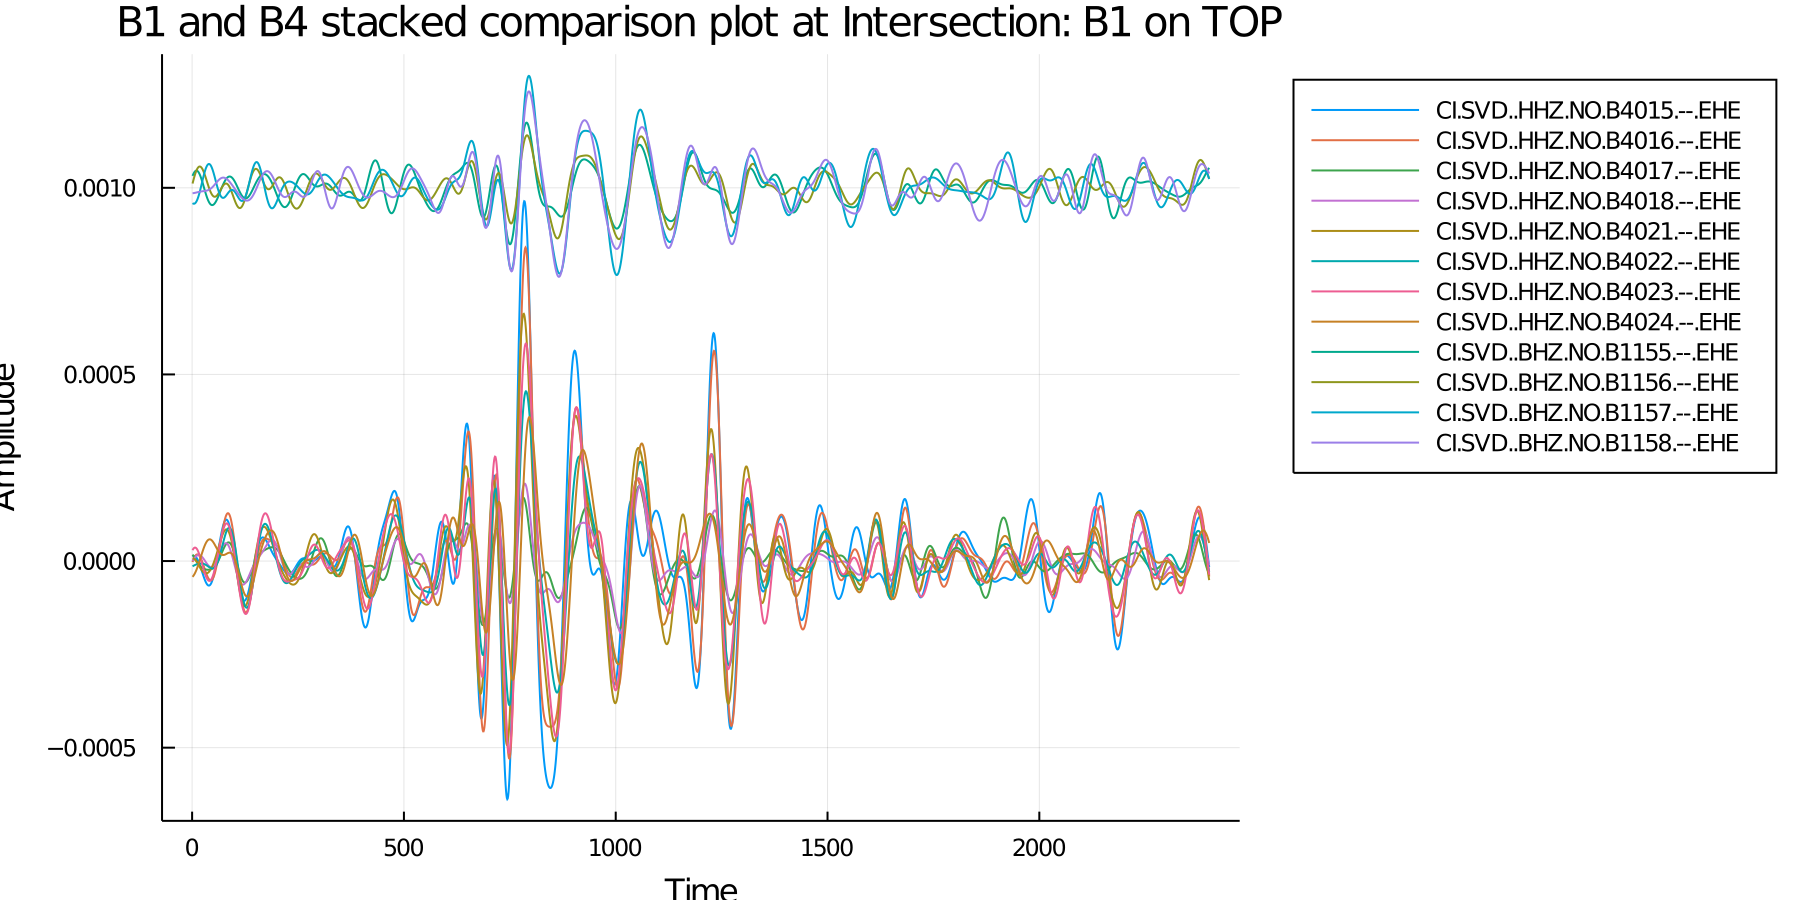

In [170]:
# Plot together to compare amplitudes
B1_and_B4 = plot(title="B1 and B4 stacked comparison plot at Intersection: B1 on TOP", ylabel="Amplitude",
                 xlabel="Time", legend=:outertopright, size=(900,450), dpi=200, pad=0.5)
for corr in B4_stacked_ZE
    plot!(B1_and_B4, bandpass(taper(corr), 0.1,0.35).corr[4800:7200], label= corr.name)
end
for corr in B1_stacked_ZE
    plot!(B1_and_B4, bandpass(taper(corr), 0.1,0.35).corr[4800:7200] .+ 0.001, label= corr.name)
end
png("/Users/julianschmitt/Desktop/SeisPlots2/debug_stack/ZE_B1_B4_intersection_stacked_comparison.png")
display(B1_and_B4)

In [181]:
f = jldopen(CHN_B4_files[1], "r")
keys(f["ZZ"])

27-element Array{String,1}:
 "2017-02-01"
 "2017-02-02"
 "2017-02-03"
 "2017-02-04"
 "2017-02-05"
 "2017-02-06"
 "2017-02-07"
 "2017-02-08"
 "2017-02-09"
 "2017-02-10"
 "2017-02-11"
 "2017-02-12"
 "2017-02-14"
 ⋮
 "2017-02-17"
 "2017-02-18"
 "2017-02-19"
 "2017-02-20"
 "2017-02-21"
 "2017-02-22"
 "2017-02-23"
 "2017-02-24"
 "2017-02-25"
 "2017-02-26"
 "2017-02-27"
 "2017-02-28"

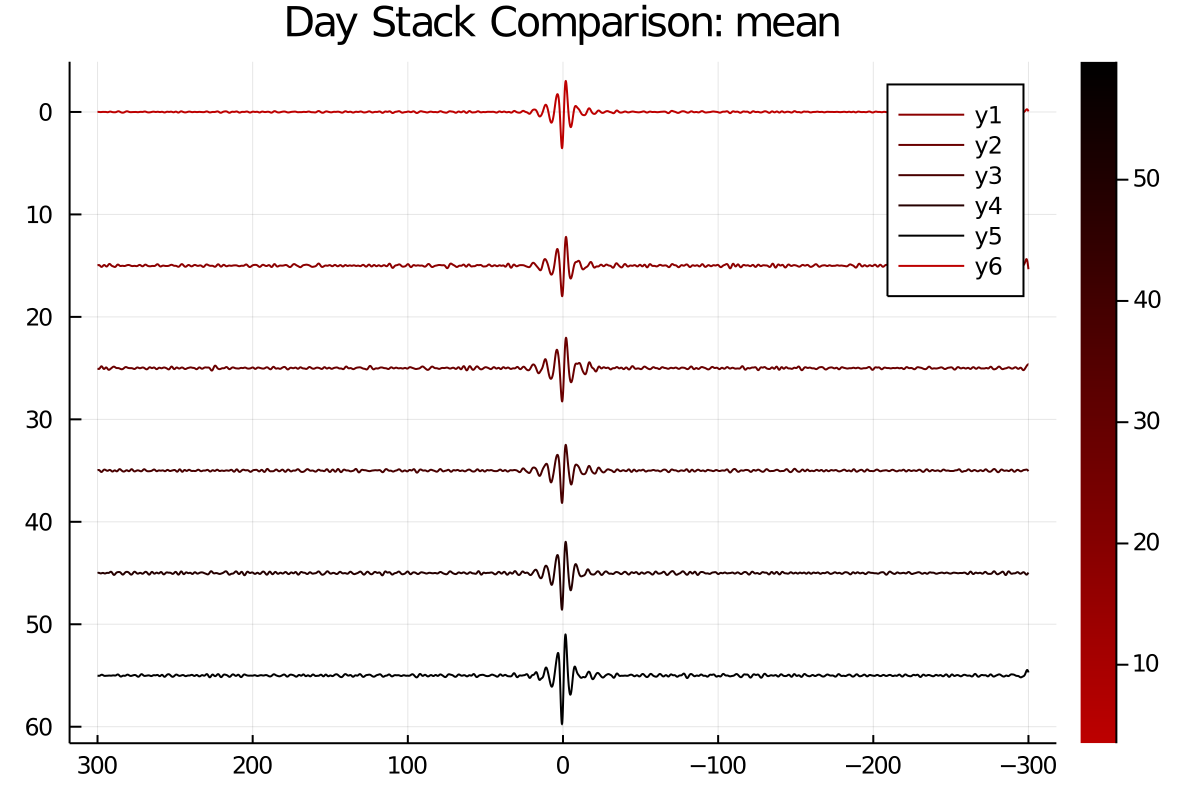

Any["2017-02-01", "2017-02-02", "2017-02-03", "2017-02-04", "2017-02-05", "Stacked"]


In [179]:
pstack = plot(title="Day Stack Comparison: mean", flip = true)

# extract correlations and maximum amplitudes
corrs = [f["ZZ"][k] for k in keys(f["ZZ"])[1:5]]
corr_mean = SeisNoise.stack(sum(corrs), allstack=true, stacktype=mean)
corr_mean = bandpass(corr_mean,0.1,0.35).corr .*10e2
#corrs = [bandpass(corr, 0.1,0.35).corr for corr in corrs]
processed = Array{Array{Float64, 2}}(undef,0)
for (ind, corr) in enumerate(corrs)
    tcorr = bandpass(corr, 0.1, 0.35)
    tcorr.corr = tcorr.corr .*10e2 
    push!(processed, tcorr.corr .+ (10*ind+5))
end
push!(processed, corr_mean)
max_amp = [maximum(abs.(corr)) for corr in processed]
push!(max_amp, maximum(abs.(corr_mean)))
T = collect(-300.:1/20:300.)
label = Array{Any, 1}(undef, 0)
for corr in corrs
    push!(label, "$(Date(u2d(corr.t[1])))")
end
push!(label, "Stacked")
plot!(pstack, T, processed, color = :cm_maxamp, line_z = max_amp', dpi=200)
png(pstack, "/Users/julianschmitt/Desktop/SeisPlots2/Day_stack_comparison_mean.png")
display(pstack)
    

In [306]:
CHN_B1_files

2-element Array{String,1}:
 "/Volumes/T7/seis_data/nodes/corr_large/2019/December/CI.CHN..NO.B1156.--.jld2"
 "/Volumes/T7/seis_data/nodes/corr_large/2019/November/CI.CHN..NO.B1156.--.jld2"

In [13]:
#corrs = [f["ZZ"][k] for k in keys(f["ZZ"])]
B1_f = jldopen(CHN_B1_files[1])
B1_f2  = jldopen(CHN_B1_files[2])
B1_corrs = vcat([B1_f["ZZ"][k] for k in keys(B1_f["ZZ"])], [B1_f2["ZZ"][k] for k in keys(B1_f2["ZZ"])])

In [296]:
B1_data = sum_corrs(B1_corrs)
cc_medianmute!(B1_data, 1.5, false)
println(size(B1_data.corr))
SeisNoise.stack!(B1_data, allstack=true, stacktype=mean)
bandpass!(B1_data, 0.1,0.35)
plot(B1_data.corr)
plot!(title="32 days stacked B1 1156 ZZ from CHN", legend=false, xlabel = "Samples (fs=20)", 
    ylabel="Amplitude", dpi=200)
png("/Users/julianschmitt/Desktop/SeisPlots2/1.5_B1_new_stack_example.png")

(12001, 32)


## B4 correlations

In [297]:
CHN_B4_files = glob("nodes/corr_large/*/*/CI.CHN..NO.B4060*", "/Volumes/T7/seis_data")
B4_f1 = jldopen(CHN_B4_files[1])
B4_f2  = jldopen(CHN_B4_files[2])
B4_corrs = vcat([B4_f1["ZZ"][k] for k in keys(B4_f1["ZZ"])], 
                [B4_f2["ZZ"][k] for k in keys(B4_f2["ZZ"])]);

In [298]:
typeof(B4_corrs)

Array{CorrData,1}

In [299]:
B4_data = sum_corrs(B4_corrs)
cc_medianmute!(B4_data, 1.5, false)
println(size(B4_data.corr))
SeisNoise.stack!(B4_data, allstack=true, stacktype=mean)
bandpass!(B4_data, 0.1,0.35)
plot(B4_data.corr)
plot!(title="33 days stacked B4 4060 ZZ from CHN", legend=false, 
    xlabel = "Samples (fs=20)", ylabel="Amplitude", dpi=200)
png("/Users/julianschmitt/Desktop/SeisPlots2/1.5_B4_new_stack_example.png")

(12001, 29)


## G1 Data

In [300]:
CHN_G1_files = glob("nodes/corr_large/*/*/CI.CHN..NO.G1024*", "/Volumes/T7/seis_data")
G1_f1 = jldopen(CHN_G1_files[1])
G1_f2 = jldopen(CHN_G1_files[2])
G1_corrs = vcat([G1_f1["ZZ"][k] for k in keys(G1_f1["ZZ"])], 
                [G1_f2["ZZ"][k] for k in keys(G1_f2["ZZ"])]);


In [301]:
G1_data = sum_corrs(G1_corrs)
cc_medianmute!(G1_data, 1.5, false)
println(size(G1_data.corr))
SeisNoise.stack!(G1_data, allstack=true, stacktype=mean)
bandpass!(G1_data, 0.1,0.35)
plot(G1_data.corr)
plot!(title="33 days stacked G1 1024 ZZ from CHN", legend=false, 
    xlabel = "Samples (fs=20)", ylabel="Amplitude", dpi=200)
png("/Users/julianschmitt/Desktop/SeisPlots2/1.5_G1_new_stack_example.png")

(12001, 33)


In [304]:
B4_int_files = glob("nodes/corr_large/*/*/CI.CHN..NO.B4024*", "/Volumes/T7/seis_data")
B4_f1 = jldopen(B4_int_files[1])
B4_f2 = jldopen(B4_int_files[2])
B4_f3 = jldopen(B4_int_files[3])

B4_corrs = vcat([B4_f1["ZZ"][k] for k in keys(B4_f1["ZZ"])], 
                [B4_f2["ZZ"][k] for k in keys(B4_f2["ZZ"])],
                [B4_f3["ZZ"][k] for k in keys(B4_f3["ZZ"])]);


In [305]:
B4_data = sum_corrs(B4_corrs)
cc_medianmute!(B4_data, 1.5, false)
println(size(B4_data.corr))
SeisNoise.stack!(B4_data, allstack=true, stacktype=mean)
bandpass!(B4_data, 0.1,0.35)
plot(B4_data.corr)
plot!(title="36 days stacked B4 4024 ZZ from CHN", legend=false, 
    xlabel = "Samples (fs=20)", ylabel="Amplitude", dpi=200)
png("/Users/julianschmitt/Desktop/SeisPlots2/1.5_B4_int_new_stack_example.png")

(12001, 36)


In [14]:
#[println(corr.name) for corr in corrs]
summed_corr =sum(corrs)
cc_medianmute!(summed_corr,0.9)
summed_corr 

In [214]:
#cc_medianmute(summed_corr.corr)[1]
# dim2ar = Array{Float64, 2}(undef, 12001, 21)
# dim2ar[:, 1] = corrs[1].corr
# dim2ar
size(corrs[1].corr)

(12001, 1)

In [229]:
function sum_corrs(corrs::Array{CorrData,1})
    """ Implement sum function on array of corrs before stacking"""
    sum_corr = Array{Float64, 2}(undef, size(corrs[1].corr)[1], length(corrs))
    for (ind, corr) in enumerate(corrs)
        sum_corr[:, ind] = corr.corr[:]
    end
    corr = deepcopy(corrs[1]) # keep metadata from first correlation
    corr.corr = sum_corr # update array of correlations
    return corr
end      

sum_corrs (generic function with 1 method)

In [249]:
new_method = sum_corrs(corrs)
cc_medianmute!(new_method, 3., false)
SeisNoise.stack!(new_method, allstack=true, stacktype = mean)
new_method

CorrData with 1 Corrs
      NAME: "CI.CHN..HHZ.NO.B4060.--.EHZ"      
        ID: "2017-02-01"                       
       LOC: 33.9988 N, -117.68 E, 208.0 m
      COMP: "ZZ"                               
   ROTATED: false                              
 CORR_TYPE: "CC"                               
        FS: 20.0
      GAIN: 1.0
   FREQMIN: 0.05
   FREQMAX: 9.9
    CC_LEN: 3600.0
   CC_STEP: 3600.0
  WHITENED: false                              
 TIME_NORM: ""                                 
      RESP: a0 1.0, f0 1.0, 0z, 0p
      MISC: 0 entries                          
     NOTES: 9 entries                          
      DIST: 2.92028
       AZI: 71.1097
       BAZ: 251.126
    MAXLAG: 300.0
         T: 2017-02-01T00:00:00                …
      CORR: 12001×1 Array{Float64,2}           


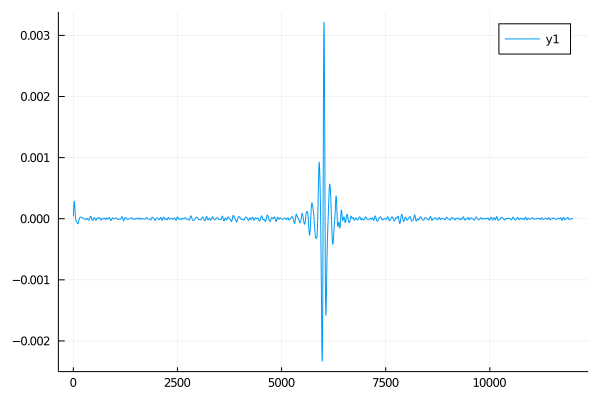

In [254]:
processed = bandpass(new_method, 0.1,0.35)
plot(processed.corr)
# old_method =bandpass(SeisNoise.stack(sum(corrs), allstack=true, stacktype=mean), 0.1,0.35)
# plot!(old_method.corr)

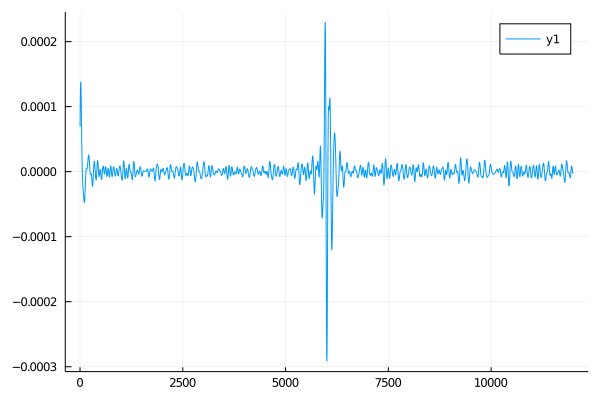

In [253]:
old_method =bandpass(SeisNoise.stack(sum(corrs), allstack=true, stacktype=mean), 0.1,0.35)
#plot(old_method.corr)
plot(processed.corr-old_method.corr)

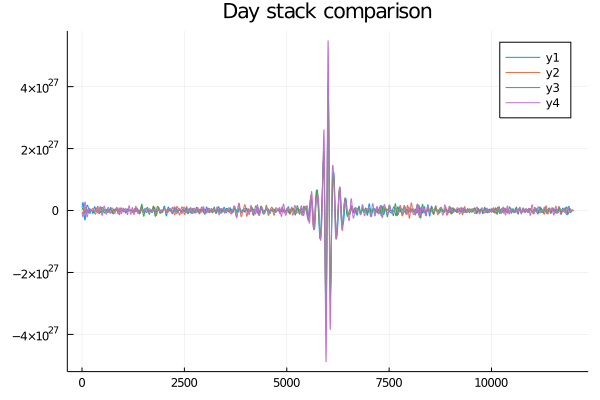

In [110]:
corrs = [f["ZZ"][k] for k in keys(f["ZZ"])[2:5]]
pstack = plot(title="Day stack comparison")
for (ind, corr) in enumerate(corrs)
    bandpass!(corr, 0.1, 0.35)
    corr.corr = corr.corr .*10e2 .+ ind*10
    plot!(pstack, corr.corr)
end
display(pstack)

In [106]:
corrs = [f["ZZ"][k] for k in keys(f["ZZ"])[4:5]]
corrs[1].corr

12001×1 Array{Float64,2}:
  2.3613584912171833e22
  2.6990793239176367e22
  3.038044202250701e22
  3.3764584666489546e22
  3.7124688327805665e22
  4.044174384496401e22
  4.36963817475853e22
  4.686899356909611e22
  4.993985763490505e22
  5.2889268452783034e22
  5.569766879338038e22
  5.834578351692657e22
  6.0814754177461546e22
  ⋮
 -2.1499149807156113e21
 -1.865939241639671e21
 -1.6083544618571992e21
 -1.3763123306896255e21
 -1.1687663110722207e21
 -9.8450365072059e20
 -8.221771190924239e20
 -6.80336068488818e20
 -5.5745644041778627e20
 -4.5196936552422585e20
 -3.6228803665567724e20
 -2.868325696188984e20

In [109]:
f["ZZ"]["2017-02-01"].corr

12001×1 Array{Float64,2}:
 -3.1972062395922153e34
 -3.6206471740768125e34
 -4.04526148031484e34
 -4.468801369307076e34
 -4.88894976710375e34
 -5.303334519905498e34
 -5.709543346750051e34
 -6.105139436126759e34
 -6.487677576189497e34
 -6.8547207024024535e34
 -7.20385674150681e34
 -7.532715626685914e34
 -7.838986355771737e34
  ⋮
  6.663291180899526e33
  6.122900610997014e33
  5.590791075003652e33
  5.0718374993568523e33
  4.570321188144674e33
  4.089919952181705e33
  3.6337063255991425e33
  3.2041536092270424e33
  2.803149389632925e33
  2.432016096726145e33
  2.0915380822650943e33
  1.7819946272920498e33

In [246]:
function cc_medianmute(A::AbstractArray, cc_medianmute_α::Float64 = 10.0)
    """
        Remove noisy correlation windows before stacking
        - Remove if average noise is greater than 10x the average
    """
    T, N = size(A)
    cc_maxamp = vec(maximum(abs.(A), dims=1))
    cc_medianmax = median(cc_maxamp)
    inds = findall(x-> x <= cc_medianmute_α*cc_medianmax,cc_maxamp)
    return A[:, inds], inds
end
remove_medianmute(C::CorrData, inds) = (return C.t[inds])
function cc_medianmute2!(C::CorrData, cc_medianmute_α::Float64 = 10.0, bool::Bool = true)
    C.corr, inds = cc_medianmute(C.corr, cc_medianmute_α)
    if bool
        C.t = remove_medianmute(C, inds)
    end
    return nothing
end

cc_medianmute! (generic function with 3 methods)